In [60]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

In [61]:
inversionFree = True

c = torch.randn((100, 1), requires_grad=False)
d = torch.randn((100, 1), requires_grad=False)

def f(x, y):
    return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

def g(x, y):
    return 0.5 * torch.linalg.norm(x-y)**2

In [62]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((100, 100))
    dgdyx = torch.zeros((100, 100))

    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True)[0][:, 0]

    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

In [63]:
def solve(x, y, alpha, epsilon, deltaT = 0.01, finalTime=5, warmStart=0):
    deltaX = torch.zeros_like(x)
    lossF, lossG, LLerror = [], [], []
    for i in range(int(finalTime // deltaT)):
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        with torch.no_grad():
            lossF.append(f(x, y)); lossG.append(g(x, y));
            if inversionFree:
                a = 2 * dgdyy @ dgdy
                b = -2 * dgdy.T @ dgdyx @ deltaX - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                d = a * torch.maximum(torch.Tensor([0]), a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

                deltaX = -dfdx - dgdyx.T @ d
                deltaY = -dfdy - d
                LLerror.append(torch.linalg.norm(dgdy, 2).detach().numpy() - epsilon)
            else:
                gHessianInv = dgdyy.inverse()
                deltaX = -dfdx - dgdyx.T @ gHessianInv @ dfdy
                deltaY = -gHessianInv @ (alpha * dgdy + dgdyx @ deltaX)

        if i>=warmStart:
            x = x + deltaT * deltaX
        y = y + deltaT * deltaY
    return x, y, [lossF, lossG, LLerror]

In [64]:
alpha = 0.1
epsilon = 1e-2
deltaT = 0.01; finalTime = 10;

x = torch.randn((100, 1), requires_grad=True)
y = torch.randn((100, 1), requires_grad=True)

x, y, errors = solve(x, y, alpha, epsilon, deltaT, finalTime)


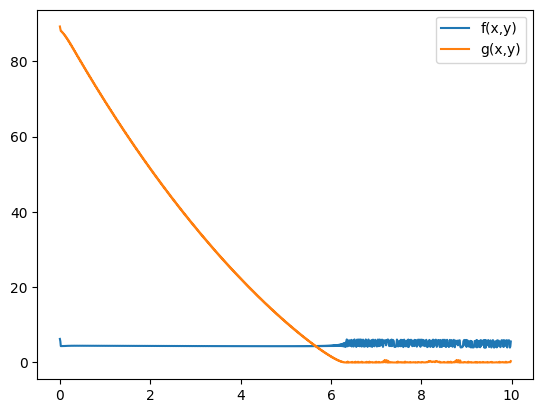

In [65]:
timeSteps = np.arange(0, len(errors[0]) * deltaT, deltaT)


plt.plot(timeSteps, errors[0], label='f(x,y)')
plt.plot(timeSteps, errors[1], label='g(x,y)')

plt.legend()
plt.show()

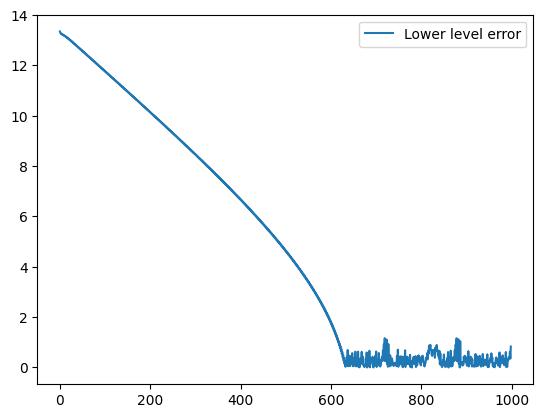

In [66]:
plt.plot(errors[2], label='Lower level error')

# plt.yscale('log')
plt.legend()
plt.show()